## Auditing Use Case 3

In this notebook, we apply the auditing tool to the third use case: _Random forest to predict health from "Hours worked per week", "Age", "Marital Status", "Occupation", "Industry", "Region"_.

We restrict the space to the seven columns `X = ("Hours worked per week", "Age", "Marital Status", "Occupation", "Industry", "Region", Health)`, and want to audit a dataset card restricting the statistics to the pairwise marginals $m(X_i,X_j)_{i\neq j}$. This space is high dimensional, which makes the problem quite complex. 

We apply the methodology developed in notebook [v4] to a bunch of synthetic data generators:

- Honest IPF.
- Cheaty IPF.
- Honest MST.
- Cheaty MST.
- synthgauge (cheaty by default).


In [1]:
import itertools
import numpy as np
import pandas as pd
import tqdm
import tqdm.notebook

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Loads of warnings coming from the sub-methods, which we don't care about.
import warnings
warnings.filterwarnings("ignore")

In [3]:
import auditing

### Parameters of the auditing

In [4]:
# How many times should records be duplicated in extremal datasets?
# The higher this number, the lower the sampling error, but the computational cost is linear in num_repeats.
num_repeats = 10  # Low!

# How many points should be selected in extremal datasets?
num_points = 10000

# Note that num_repeats * num_points is the size of the extremal datasets.

In [5]:
# How many synthetic datasets should be generated for candidate selection?
# The error most likely decreases as sqrt(num_synthetic)^{-1}, but the computational cost is linear.
num_synthetic = 10

In [6]:
# Number of datasets to generate for the second step.
num_auditing_samples = 10

### Data
Load the data in a specific format (not actually needed).

In [7]:
columns = ["Marital Status", "Occupation", "Industry", "Region", "Hours worked per week", "Age", "Health"]

In [8]:
df = pd.read_csv(
    '../../privacy-sdg-toolbox/examples/data/2011 Census Microdata Teaching File (original).csv',
)[columns].astype('category')

In [9]:
df.columns

Index(['Marital Status', 'Occupation', 'Industry', 'Region',
       'Hours worked per week', 'Age', 'Health'],
      dtype='object')

In [10]:
for column in df.columns:
    df[column] = df[column].cat.codes

In [11]:
columns = list(df.columns)
num_columns = len(df.columns)
num_cat = df.max() + 1
num_cat_int = num_cat.values
print("Size of the space:", np.prod(num_cat_int))
num_cat_int

Size of the space: 1560000


array([ 5, 10, 13, 10,  5,  8,  6], dtype=int8)

In [12]:
metadata = [
    {"name": column, "type": "finite", "representation": list(range(nc))}
    for column, nc in zip(df.columns, num_cat_int)
]

In [13]:
metadata

[{'name': 'Marital Status',
  'type': 'finite',
  'representation': [0, 1, 2, 3, 4]},
 {'name': 'Occupation',
  'type': 'finite',
  'representation': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]},
 {'name': 'Industry',
  'type': 'finite',
  'representation': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]},
 {'name': 'Region',
  'type': 'finite',
  'representation': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]},
 {'name': 'Hours worked per week',
  'type': 'finite',
  'representation': [0, 1, 2, 3, 4]},
 {'name': 'Age', 'type': 'finite', 'representation': [0, 1, 2, 3, 4, 5, 6, 7]},
 {'name': 'Health', 'type': 'finite', 'representation': [0, 1, 2, 3, 4, 5]}]

### Linear space

Define the vector space: $\phi$ is the set of all 2-way marginals.

In [14]:
def generate_kway_marginals(columns=None, k=1):
    columns = columns or range(len(num_cat_int))
    marginals = []
    for combs in itertools.combinations(columns, k):
        for values in itertools.product(*[range(num_cat_int[i]) for i in combs]):
            marginals.append(auditing.MarginalBin(combs, values))
    return marginals

In [15]:
phi = generate_kway_marginals(k=2)

In [16]:
len(phi)

1365

In [17]:
# Write the scalar product for the whole space.
# scalar_product = auditing.NaiveScalarProduct(num_cat_int)
scalar_product = auditing.LinearCompositionScalarProduct(
    auditing.HistogramScalarProduct(num_cat)
)

In [18]:
%%time
# The linear space created by the known phis.
linspan_phi = auditing.OrthogonalSpace(scalar_product, phi)

CPU times: user 21.9 s, sys: 289 ms, total: 22.2 s
Wall time: 22.6 s


In [19]:
len(linspan_phi.basis)

1095

Define the candidate set $\mathcal{C}$ of all three-way marginal bins.

Note that this is too large -- let's take a subset of smaller size.

In [20]:
C = generate_kway_marginals(k=3)

In [21]:
len(C)

17799

In [22]:
C = np.random.choice(C, replace=False, size=1000)

Define the orthogonal space $span\left<\phi\right>^\perp \cap \text{span}\left<C\right>$. This is the typical code for this:

In [23]:
# C_perp = [linspan_phi.orthogonalise(b) for b in C]
# linspan_phi_perp = auditing.OrthogonalSpace(scalar_product, C_perp)
# phi_perp_basis = [auditing.refactor_linear_combination(b) for b in linspan_phi_perp.basis]

But we can optimise this, using the internal structure of orthogonal space.

In [24]:
%%time
combined_space = auditing.OrthogonalSpace(scalar_product, phi + list(C))

CPU times: user 1min 21s, sys: 1.02 s, total: 1min 22s
Wall time: 1min 23s


In [25]:
phi_perp_basis = combined_space.basis[len(linspan_phi.basis):]

In [26]:
k = len(phi_perp_basis)
k

1000

### Auditing toolkit

In [27]:
# All possible records.
unique_records = pd.DataFrame(list(itertools.product(*[range(nc) for nc in num_cat_int])), columns=columns)

In [28]:
beta = auditing.AddedFunctions(*phi_perp_basis)
beta = auditing.refactor_linear_combination(beta)

In [29]:
%%time
auditor = auditing.Auditor(
    phi,
    unique_records,
    subsample_size=num_points,
    use_lp=False
)

CPU times: user 3min 24s, sys: 2.83 s, total: 3min 27s
Wall time: 3min 31s


Note: we have selected 3-way marginals

In [30]:
%%time
D_minus, D_plus = auditor.generate_extremal_datasets(beta, num_repeats=num_repeats)

CPU times: user 6min 47s, sys: 4min 52s, total: 11min 40s
Wall time: 11min 48s


In [31]:
D_plus.shape

(99977, 7)

In [32]:
D_minus.shape

(99985, 7)

This function selects a candidate function $g$, given a generator. It does the following:

1. Compute $\beta = \sum_{i=1}^k b_i$ and generate a pair of extremal datasets $D^-, D^+$ for $\beta$.
2. Generate synthetic datatsets from these extremal datasets, $D^{s-},D^{s+}$. 
3. Compute $\delta_i \triangleq \Delta^S b_i = b_i(D^{s-}) - b_i(D^{s+})$.
4. Estimate $g$ as $\hat{g} = \sum_{i=1}^k \frac{\delta_i}{\|\delta\|} b_i$.

Steps 2. and 3. can be repeated several times, and $\delta_i$ averaged over the runs, to reduce randomness.

In [33]:
# This is the simple implementation, but very slow (the individual factors are computed many times).

# def compute_delta_naive(D_synth_plus, D_synth_minus, phi_perp_basis):
#     delta = []
#     for b in phi_perp_basis:
#         delta.append(b(D_synth_plus).mean() - b(D_synth_minus).mean())
#     return delta

In [34]:
def compute_delta_optimised(D_synth_plus, D_synth_minus, phi_perp_basis):
    # Decompose each basis element in factors.
    factored_basis = []
    factors = set()
    for b in phi_perp_basis:
        lin_f = auditing.split_linear_combination(b)
        factored_basis.append(lin_f)
        # Add each factor in the basis to unique factors.
        for f in lin_f.keys():
            factors.add(f)
    # Compute the value of each factor over the datasets.
    # This is where the optimisation lies!
    factor_plus = {}
    factor_minus = {}
    for f in factors:
        factor_plus[f] = f(D_synth_plus).mean()
        factor_minus[f] = f(D_synth_minus).mean()
    # Finally, combine these answers.
    delta = []
    for b_factors in factored_basis:
        b_plus = 0
        b_minus = 0
        for f, a in b_factors.items():
            b_plus = b_plus + a * factor_plus[f]
            b_minus = b_minus + a * factor_minus[f]
        delta.append(b_plus - b_minus)
    return delta

In [35]:
def candidate_selection(generator, num_synth):
    # TODO: reset the auditor?
    deltas = []
    for repeat in tqdm.notebook.trange(num_synth):
        D_synth_minus = generator(D_minus)
        D_synth_plus = generator(D_plus)
        deltas.append(compute_delta_optimised(D_synth_plus, D_synth_minus, phi_perp_basis))
    deltas = np.mean(deltas, axis=0)
    scale = deltas / np.linalg.norm(deltas)
    return auditing.refactor_linear_combination(
        auditing.AddedFunctions(*[s*b for s,b in zip(scale, phi_perp_basis)])
    )

Bring together the results.

In [14]:
def auditing_plot(results, color, label):
    x = []
    y = []
    df_r = pd.DataFrame(results, columns=('real', 'synth'))
    for real, subdf in df_r.groupby('real'):
        x.append(real)
        y.append(subdf.synth.values.mean())
    plt.plot(x, y, '*-', c=color, label=label)
    x, y = zip(*results)
    ix = np.argsort(x)
    plt.plot(np.array(x)[ix], np.array(y)[ix], '.', c=color, ms=10, alpha=.2)

In [37]:
def audit(generator, num_samples, label='', verbose = True):
    if verbose:
        print("[Step 1] Selecting a candidate g...")
    g = candidate_selection(generator, num_synth=num_synthetic)
    if verbose:
        print("[Step 2] Auditing g from D^r and D^s...")
    results = auditor.audit(
        generator,
        g,
        num_samples=num_samples,
        num_repeats=num_repeats,
        iterator=tqdm.notebook.tqdm,
    )
    plt.figure(figsize=(7,7))
    auditing_plot(results, 'b', label)
    plt.xlabel("Value of $g(D_{input})$ for fixed $\\phi(D_{input})$", fontsize=15)
    plt.ylabel("Value of $g(D_{synthetic})$ generated from $D_{input}$", fontsize=15)
    plt.legend()
    return g, results

### Generators

In [38]:
from reprosyn.methods import MST, SYNTHPOP
from raw_ipf import IPF  # temporary library with optimisations.

2022-11-01 16:32:35.527636: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term


In [39]:
from mbi import Domain, Dataset, FactoredInference

In [40]:
correct_marginals = list(itertools.combinations(range(len(columns)), 2))

In [41]:
cheat_marginals = [(0, 1, 4)]  # Arbitrary! Not sure what to do here.

In [42]:
[columns[i] for i in cheat_marginals[0]]

['Marital Status', 'Occupation', 'Hours worked per week']

In [43]:
import raw_ipf
def generate_ipf(dataset, cheat = False):
    marginals = list(correct_marginals)
    if cheat:
        marginals += cheat_marginals
    ipf = raw_ipf.IPF(
        dataset=pd.DataFrame(dataset, columns=columns),
        metadata=metadata,
        size=len(dataset),
        marginals=marginals
    )
    ipf.run()
    return ipf.output.values

In [44]:
def generate_mst(dataset, cheat = False, sigma = 0.001):
    domain = Domain(columns, num_cat_int)
    dataset_mbi = Dataset(pd.DataFrame(dataset, columns=columns), domain)
    # Get measurements for 1-way histogram.
    marginals = list(correct_marginals)
    if cheat:
        marginals += cheat_marginals
    marginals = [[columns[i] for i in m] for m in marginals]
    histograms = [dataset_mbi.project(m).datavector() for m in marginals]
    measurements = [(np.eye(h.size), h, sigma, m) for m, h in zip(marginals, histograms)]
    # Use the MBI procedure for the rest.
    engine = FactoredInference(domain, log=True, iters=200)
    model = engine.estimate(measurements, engine='MD')
    synth = model.synthetic_data(rows=len(dataset))
    return synth.df.values

In [45]:
def generate_synthpop(dataset, cheat = False):
    model = SYNTHPOP(
        dataset=pd.DataFrame(dataset, columns=columns),
        metadata=metadata,
        size=len(dataset)
    )
    model.run()
    return model.output.values

Grouping them together.

In [55]:
# List of method name, whether it cheats, and the function.

methods = [
    ("IPF-Honest", False, generate_ipf),
    ("IPF-Cheat", True, lambda data: generate_ipf(data, cheat=True)),
    ("MST-Honest", False, generate_mst),
    ("MST-Cheat", True, lambda data: generate_mst(data, cheat=True)),
    ("SynthPop", True, generate_synthpop)
]

Run.

In [47]:
results = []

====== MST-Honest ======
[Step 1] Selecting a candidate g...


  0%|          | 0/10 [00:00<?, ?it/s]

Total clique size: 1560000
iteration		time		l1_loss		l2_loss		feasibility
0.00		0.00		123618569.23		9587407127403.85		0.00
50.00		19.11		172823.75		39916215.36		0.00
100.00		37.89		2101.60		7869.82		0.00
150.00		56.52		37.54		2.58		0.00
Total clique size: 1560000
iteration		time		l1_loss		l2_loss		feasibility
0.00		0.00		123775695.64		9602463636634.62		0.00
50.00		17.44		159464.45		38086791.29		0.00
100.00		35.38		1560.57		6285.70		0.00
150.00		53.43		25.13		1.94		0.00
Total clique size: 1560000
iteration		time		l1_loss		l2_loss		feasibility
0.00		0.00		123618569.23		9587407127403.85		0.00
50.00		19.04		172823.75		39916215.36		0.00
100.00		38.33		2101.60		7869.82		0.00
150.00		57.81		37.54		2.58		0.00
Total clique size: 1560000
iteration		time		l1_loss		l2_loss		feasibility
0.00		0.00		123775695.64		9602463636634.62		0.00
50.00		17.92		159464.45		38086791.29		0.00
100.00		35.91		1560.57		6285.70		0.00
150.00		53.81		25.13		1.94		0.00
Total clique size: 1560000
iteration		time		l1_loss	

  0%|          | 0/10 [00:00<?, ?it/s]

Total clique size: 1560000
iteration		time		l1_loss		l2_loss		feasibility
0.00		0.00		123876736.92		9607684703461.54		0.00
50.00		19.14		160652.41		37652190.39		0.00
100.00		37.78		2039.50		7029.62		0.00
150.00		56.89		35.58		2.28		0.00
Total clique size: 1560000
iteration		time		l1_loss		l2_loss		feasibility
0.00		0.00		123876736.92		9607684703461.54		0.00
50.00		17.90		160652.41		37652190.39		0.00
100.00		35.97		2039.50		7029.62		0.00
150.00		54.27		35.58		2.28		0.00
Total clique size: 1560000
iteration		time		l1_loss		l2_loss		feasibility
0.00		0.00		123876736.92		9607684703461.54		0.00
50.00		17.51		160652.41		37652190.39		0.00
100.00		35.18		2039.50		7029.62		0.00
150.00		53.05		35.58		2.28		0.00
Total clique size: 1560000
iteration		time		l1_loss		l2_loss		feasibility
0.00		0.00		123876736.92		9607684703461.54		0.00
50.00		17.27		160652.41		37652190.39		0.00
100.00		34.96		2039.50		7029.62		0.00
150.00		52.69		35.58		2.28		0.00
Total clique size: 1560000
iteration		time		l1_loss	

  0%|          | 0/10 [00:00<?, ?it/s]

Total clique size: 1560000
iteration		time		l1_loss		l2_loss		feasibility
0.00		0.00		123575218.08		9591476637403.85		0.00
50.00		21.67		173487.18		39553298.58		0.00
100.00		42.85		2059.25		7536.17		0.00
150.00		63.60		35.75		2.37		0.00
Total clique size: 1560000
iteration		time		l1_loss		l2_loss		feasibility
0.00		0.00		123575218.08		9591476637403.85		0.00
50.00		18.30		173487.18		39553298.58		0.00
100.00		38.34		2059.25		7536.17		0.00
150.00		60.47		35.75		2.37		0.00
Total clique size: 1560000
iteration		time		l1_loss		l2_loss		feasibility
0.00		0.00		123575218.08		9591476637403.85		0.00
50.00		20.84		173487.18		39553298.58		0.00
100.00		41.54		2059.25		7536.17		0.00
150.00		62.52		35.75		2.37		0.00
Total clique size: 1560000
iteration		time		l1_loss		l2_loss		feasibility
0.00		0.00		123575218.08		9591476637403.85		0.00
50.00		21.12		173487.18		39553298.58		0.00
100.00		41.89		2059.25		7536.17		0.00
150.00		62.87		35.75		2.37		0.00
Total clique size: 1560000
iteration		time		l1_loss	

  0%|          | 0/10 [00:00<?, ?it/s]

Total clique size: 1560000
iteration		time		l1_loss		l2_loss		feasibility
0.00		0.00		136445929.23		10099796177403.85		0.00
50.00		21.15		1040899.34		1734488026.96		0.00
100.00		42.18		102055.27		17267274.99		0.00
150.00		64.37		10700.02		231983.40		0.00
Total clique size: 1560000
iteration		time		l1_loss		l2_loss		feasibility
0.00		0.00		136501431.64		10101305078634.62		0.00
50.00		20.52		992653.26		1557111752.70		0.00
100.00		41.90		79197.56		13696304.49		0.00
150.00		63.89		8268.71		199635.57		0.00
Total clique size: 1560000
iteration		time		l1_loss		l2_loss		feasibility
0.00		0.00		136445929.23		10099796177403.85		0.00
50.00		21.70		1040899.34		1734488026.96		0.00
100.00		43.10		102055.27		17267274.99		0.00
150.00		64.88		10700.02		231983.40		0.00
Total clique size: 1560000
iteration		time		l1_loss		l2_loss		feasibility
0.00		0.00		136501431.64		10101305078634.62		0.00
50.00		21.60		992653.26		1557111752.70		0.00
100.00		41.81		79197.56		13696304.49		0.00
150.00		63.46		8268.71		19

  0%|          | 0/10 [00:00<?, ?it/s]

Total clique size: 1560000
iteration		time		l1_loss		l2_loss		feasibility
0.00		0.00		140843776.00		10566738717615.38		0.00
50.00		21.14		2272926.21		8758707372.71		0.00
100.00		42.50		387740.63		349806895.83		0.00
150.00		63.81		76533.64		21567964.89		0.00
Total clique size: 1560000
iteration		time		l1_loss		l2_loss		feasibility
0.00		0.00		140843776.00		10566738717615.38		0.00
50.00		20.18		2272926.21		8758707372.71		0.00
100.00		41.80		387740.63		349806895.83		0.00
150.00		63.13		76533.64		21567964.89		0.00
Total clique size: 1560000
iteration		time		l1_loss		l2_loss		feasibility
0.00		0.00		140843776.00		10566738717615.38		0.00
50.00		21.01		2272926.21		8758707372.71		0.00
100.00		42.35		387740.63		349806895.83		0.00
150.00		64.23		76533.64		21567964.89		0.00
Total clique size: 1560000
iteration		time		l1_loss		l2_loss		feasibility
0.00		0.00		140843776.00		10566738717615.38		0.00
50.00		21.20		2272926.21		8758707372.71		0.00
100.00		42.78		387740.63		349806895.83		0.00
150.00		64.

  0%|          | 0/10 [00:00<?, ?it/s]

Total clique size: 1560000
iteration		time		l1_loss		l2_loss		feasibility
0.00		0.00		145111429.23		11353520546153.85		0.00
50.00		18.25		1644982.62		5654313420.98		0.00
100.00		37.69		206192.58		113616657.07		0.00
150.00		56.73		37009.63		5679020.84		0.00
Total clique size: 1560000
iteration		time		l1_loss		l2_loss		feasibility
0.00		0.00		145111429.23		11353520546153.85		0.00
50.00		17.96		1644982.62		5654313420.98		0.00
100.00		36.75		206192.58		113616657.07		0.00
150.00		55.81		37009.63		5679020.84		0.00
Total clique size: 1560000
iteration		time		l1_loss		l2_loss		feasibility
0.00		0.00		145111429.23		11353520546153.85		0.00
50.00		17.92		1644982.62		5654313420.98		0.00
100.00		36.43		206192.58		113616657.07		0.00
150.00		55.56		37009.63		5679020.84		0.00
Total clique size: 1560000
iteration		time		l1_loss		l2_loss		feasibility
0.00		0.00		145111429.23		11353520546153.85		0.00
50.00		17.97		1644982.62		5654313420.98		0.00
100.00		36.44		206192.58		113616657.07		0.00
150.00		55.40	

  0%|          | 0/10 [00:00<?, ?it/s]

train_Marital Status
train_Occupation
train_Industry
train_Region
train_Hours worked per week
train_Age
train_Health
generate_Marital Status
generate_Occupation
generate_Industry
generate_Region
generate_Hours worked per week
generate_Age
generate_Health
train_Marital Status
train_Occupation
train_Industry
train_Region
train_Hours worked per week
train_Age
train_Health
generate_Marital Status
generate_Occupation
generate_Industry
generate_Region
generate_Hours worked per week
generate_Age
generate_Health
train_Marital Status
train_Occupation
train_Industry
train_Region
train_Hours worked per week
train_Age
train_Health
generate_Marital Status
generate_Occupation
generate_Industry
generate_Region
generate_Hours worked per week
generate_Age
generate_Health
train_Marital Status
train_Occupation
train_Industry
train_Region
train_Hours worked per week
train_Age
train_Health
generate_Marital Status
generate_Occupation
generate_Industry
generate_Region
generate_Hours worked per week
generate_

  0%|          | 0/10 [00:00<?, ?it/s]

train_Marital Status
train_Occupation
train_Industry
train_Region
train_Hours worked per week
train_Age
train_Health
generate_Marital Status
generate_Occupation
generate_Industry
generate_Region
generate_Hours worked per week
generate_Age
generate_Health
train_Marital Status
train_Occupation
train_Industry
train_Region
train_Hours worked per week
train_Age
train_Health
generate_Marital Status
generate_Occupation
generate_Industry
generate_Region
generate_Hours worked per week
generate_Age
generate_Health
train_Marital Status
train_Occupation
train_Industry
train_Region
train_Hours worked per week
train_Age
train_Health
generate_Marital Status
generate_Occupation
generate_Industry
generate_Region
generate_Hours worked per week
generate_Age
generate_Health
train_Marital Status
train_Occupation
train_Industry
train_Region
train_Hours worked per week
train_Age
train_Health
generate_Marital Status
generate_Occupation
generate_Industry
generate_Region
generate_Hours worked per week
generate_

  0%|          | 0/10 [00:00<?, ?it/s]

train_Marital Status
train_Occupation
train_Industry
train_Region
train_Hours worked per week
train_Age
train_Health
generate_Marital Status
generate_Occupation
generate_Industry
generate_Region
generate_Hours worked per week
generate_Age
generate_Health
train_Marital Status
train_Occupation
train_Industry
train_Region
train_Hours worked per week
train_Age
train_Health
generate_Marital Status
generate_Occupation
generate_Industry
generate_Region
generate_Hours worked per week
generate_Age
generate_Health
train_Marital Status
train_Occupation
train_Industry
train_Region
train_Hours worked per week
train_Age
train_Health
generate_Marital Status
generate_Occupation
generate_Industry
generate_Region
generate_Hours worked per week
generate_Age
generate_Health
train_Marital Status
train_Occupation
train_Industry
train_Region
train_Hours worked per week
train_Age
train_Health
generate_Marital Status
generate_Occupation
generate_Industry
generate_Region
generate_Hours worked per week
generate_

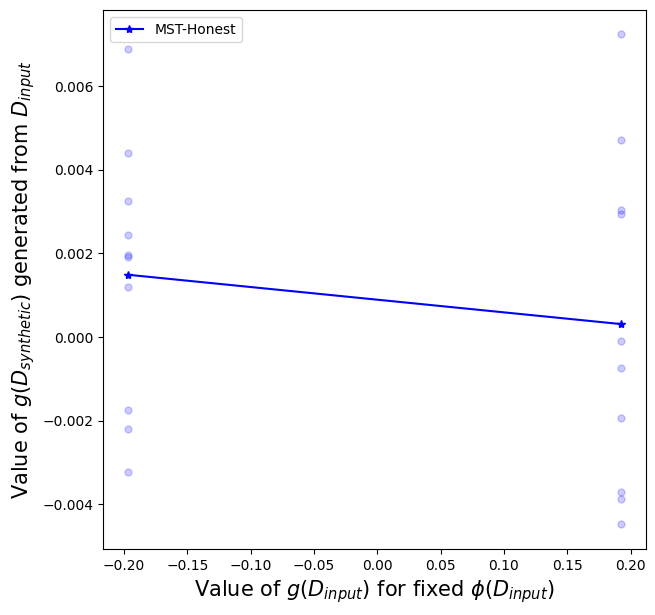

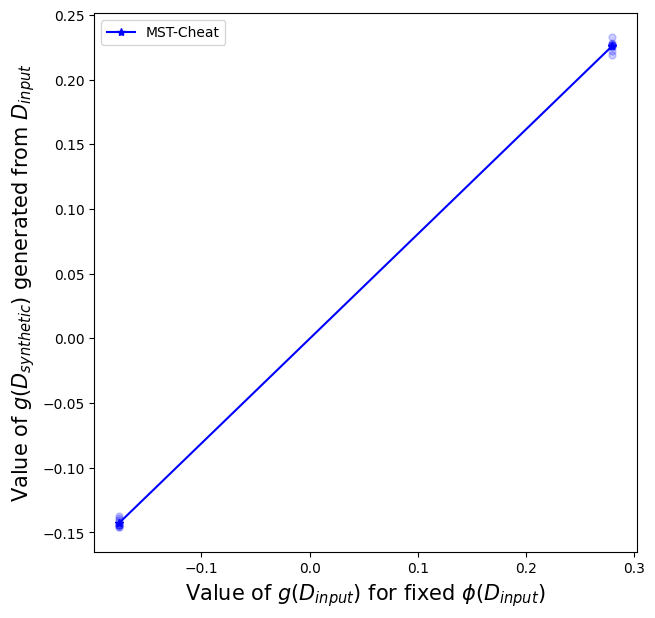

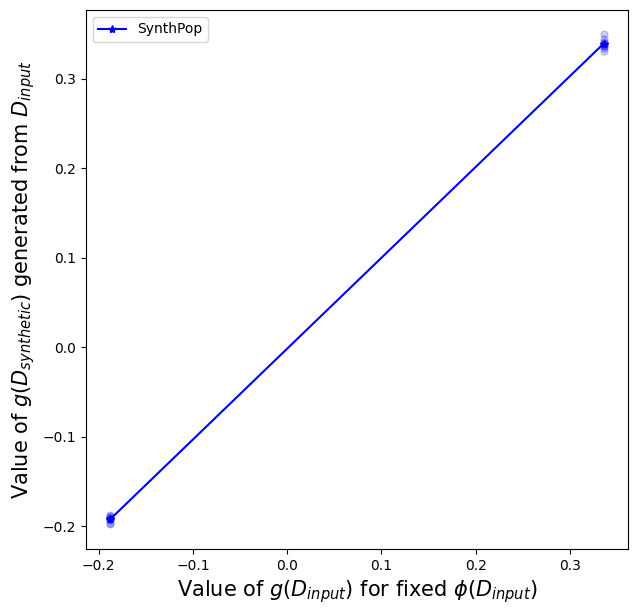

In [56]:
for name, cheat_flag, method in methods:
    print(f'====== {name} ======')
    results.append((audit(method, num_auditing_samples, name), name, cheat_flag))
    print('\n')

In [15]:
import pickle

In [58]:
with open('results-auditing-case3.pickle', 'wb') as ff:
    pickle.dump(results, ff)

## Results

In [16]:
with open('results-auditing-case3.pickle', 'rb') as ff:
    results = pickle.load(ff)

### Figure for the differences

In [17]:
renaming = {
    "IPF-Honest": "IPF (Honest)",
    "IPF-Cheat": "IPF (Dishonest)",
    "MST-Honest": "MST (Honest)",
    "MST-Cheat": "MST (Dishonest)",
    "SynthPop": "SynthPop"
}

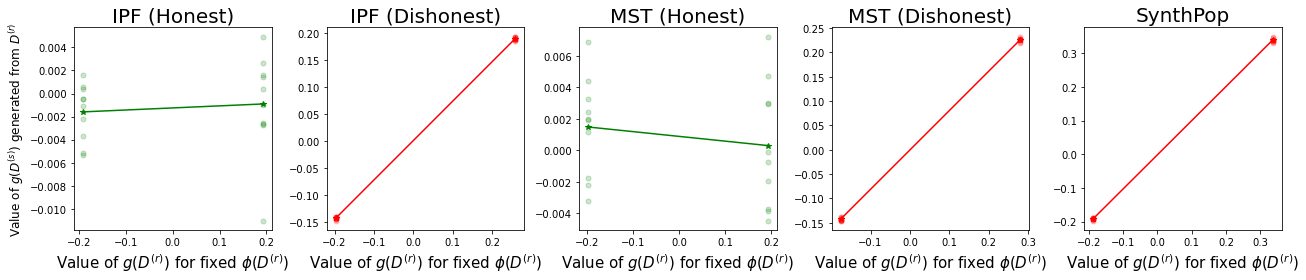

In [18]:
plt.figure(figsize=(18, 4))

i = 1
for r, name, cheat_flag in results:
    plt.subplot(1, len(results), i)
    auditing_plot(r[1], 'r' if cheat_flag else 'g', name)
    plt.xlabel("Value of $g(D^{(r)})$ for fixed $\\phi(D^{(r)})$", fontsize=15)
    if i==1:
        plt.ylabel("Value of $g(D^{(s)})$ generated from $D^{(r)}$", fontsize=12)
    plt.title(renaming[name], fontsize=20)
    i += 1

plt.tight_layout()
plt.savefig("auditing_usecase3.pdf");

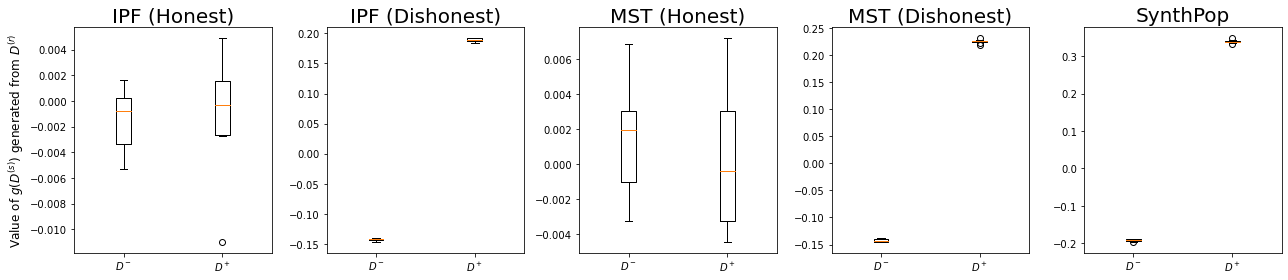

In [19]:
def better_plot(results, color, label):
    x = []
    y = []
    df_r = pd.DataFrame(results, columns=('real', 'synth'))
    for real, subdf in df_r.groupby('real'):
        x.append(real)
        y.append(subdf.synth.values)
#     plt.boxplot(y, labels=[f"{i:.2f}" for i in x])
    plt.boxplot(y, labels=["$D^-$", "$D^+$"])

plt.figure(figsize=(18, 4))

i = 1
for r, name, cheat_flag in results:
    plt.subplot(1, len(results), i)
    better_plot(r[1], 'r' if cheat_flag else 'g', name)
#     plt.xlabel("Value of $g(D^{(r)})$ for fixed $\\phi(D^{(r)})$", fontsize=15)
    if i==1:
        plt.ylabel("Value of $g(D^{(s)})$ generated from $D^{(r)}$", fontsize=12)
    plt.title(renaming[name], fontsize=20)
    i += 1

plt.tight_layout()
plt.savefig("auditing_usecase3.pdf");

### Statistical test

In [20]:
from scipy.stats import ttest_ind

In [21]:
for r, name, cheat_flag in results:
    x = [x[1] for x in r[1]]
    t_test_result = ttest_ind(x[:num_auditing_samples], x[num_auditing_samples:])
    print(f"{name} -- [{cheat_flag}]", '\t', t_test_result.pvalue)

IPF-Honest -- [False] 	 0.669761987212983
IPF-Cheat -- [True] 	 5.719051810537643e-35
MST-Honest -- [False] 	 0.47271989729217845
MST-Cheat -- [True] 	 2.2736490693781117e-33
SynthPop -- [True] 	 3.692639769296051e-34
